In [1]:
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import (
    focus_fixed_sampling,
    angular_spectrum
)
from prysm.propagation import (Wavefront as WF,
                               angular_spectrum_transfer_function,
                               Q_for_sampling)

from prysm.geometry import circle,spider
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes
)

from prysm.fttools import (fourier_resample,
                           crop_center,
                           pad2d,
)

from prysm import mathops, conf
mathops.set_backend_to_cupy()
# conf.config.precision = 32
from astropy.io import fits

from prysm.mathops import (np,
                           fft,
                           interpolate,
                           ndimage)

import matplotlib.pyplot as plt

import sys
from lina.phase_retrieval import ADPhaseRetireval, ParallelADPhaseRetrieval

from psd_utils import PSDUtils

from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator

In [182]:
global WFE_MAPS_PATH
WFE_MAPS_PATH = '/home/derbyk/src/stp_wfe_maps/telescope/'

global M1_MAP_FN
M1_MAP_FN = 'M1_goal_map.fits'

global M2_MAP_FN
M2_MAP_FN = 'M2_map.fits'

global M3_MAP_FN
M3_MAP_FN = 'M3_map.fits'

global M4_MAP_FN
M4_MAP_FN = 'M4_map.fits'

class telescope:

    def __init__(self, 
                 npix,
                 roi,
                 wvls, 
                 wvl_weights, 
                 src_magnitudes, 
                 src_positions,
                 defocus_values,):

        ##### MODEL PARAMETERS #####

        # user-defined
        self.npix = npix                        # beam sampling [pix]
        self.roi = roi                          # detector ROI [pix]
        self.wvls = wvls                        # wavelengths in spectrum [um]
        self.wvl_weights = wvl_weights          # weights for summing across wavelength (must sum to 1)
        self.src_magnitudes = src_magnitudes    # source magnitudes [Rmag]
        self.src_positions = src_positions      # source positions [arcsec]
        defocus_values = defocus_values         # detector axial shifts per source [waves PV]

        # imported (hard-coded for now shut up)
        D_obs = 1300                            # M2 obsurcation diameter [mm]
        D_spider = 150                          # spider diameter [mm]
        
        BD_m1 = 3.210000000000000e3 * 2         # beam diameter on M1 [mm]
        BD_m2 = 2.892063493800492e2 * 2         # beam diameter on M2 [mm]
        BD_m3 = 4.159732311628925e1 * 2         # beam diameter on M3 [mm]
        BD_m4 = 85.61819                        # beam diameter on M4 [mm]

        fno = 15                                # working F/# [unitless]
        self.efl = fno * BD_m1                  # effective focal length [mm]
        self.dx_m1 = BD_m1 / npix               # beam pixelscale on M1 [mm/pix]

        self.dx_detector = 3.76                 # detector pixelscale [um]

        shifts = defocus_values * 8 * (fno ** 2)# PV defocus [waves] -> axial shift [waves]
        wvl0 = np.mean(np.asarray(wvls))        # central wavelength [um]
        self.shifts = shifts * wvl0             # list of detector axial shifts per source [um]

        w0 = (wvl0 * 1e-6) * fno
        self.zr = (np.pi * (w0 ** 2) / (wvl0 * 1e-6)) * 1e6


        ##### CONSTRUCT MODEL #####

        # M1 grids
        x_m1, y_m1 = make_xy_grid(npix, diameter=BD_m1)
        self.r_m1, self.t_m1 = cart_to_polar(x_m1, y_m1)

        # M2 grids
        x_m2, y_m2 = make_xy_grid(npix, diameter=BD_m2)
        r_m2, t_m2 = cart_to_polar(x_m2, y_m2)

        # M3 grids
        x_m3, y_m3 = make_xy_grid(npix, diameter=BD_m3)
        r_m3, t_m3 = cart_to_polar(x_m3, y_m3)

        # M4 grids
        x_m4, y_m4 = make_xy_grid(npix, diameter=BD_m4)
        r_m4, t_m4 = cart_to_polar(x_m4, y_m4)

        # aperture
        s1 = spider(1, D_spider, x_m1, y_m1, rotation=0)
        s2 = spider(1, D_spider, x_m1, y_m1, rotation=120)
        s3 = spider(1, D_spider, x_m1, y_m1, rotation=240)
        spiders = s1 & s2 & s3
        self.aperture = (circle(BD_m1 / 2, self.r_m1) ^ circle(D_obs / 2, self.r_m1)) & spiders

        # optics
        self.surface_error_m1 = self._optic_factory(M1_MAP_FN, BD_m1)
        self.surface_error_m2 = self._optic_factory(M2_MAP_FN, BD_m2)
        self.surface_error_m3 = self._optic_factory(M3_MAP_FN, BD_m3)
        self.surface_error_m4 = self._optic_factory(M4_MAP_FN, BD_m4)

    def _optic_factory(self, fname, BD):
        
        # import header and data
        hdr = fits.getheader(WFE_MAPS_PATH + fname)
        data = fits.getdata(WFE_MAPS_PATH + fname)

        # get pixelscale and dimensions
        pixscl = hdr['PIXELSCL']
        dim = data.shape[0]

        # create data grid and interpolator
        xi = yi = np.linspace(-pixscl * dim / 2, pixscl * dim / 2, dim).get()
        interp = RegularGridInterpolator((xi, yi), data)

        # create output grid and interpolate
        xf = yf = np.linspace(-BD / 2 / 1000, BD / 2 / 1000, 512) # meters -> mm
        xf, yf = np.meshgrid(xf, yf, indexing='ij')
        interp_data = interp((xf.get(), yf.get()))

        return np.asarray(interp_data)

    def create_wavefront(self, wvl, src_magnitude,):
        
        # initialize wavefront
        wavefront = WF.from_amp_and_phase(self.aperture, None, wvl, self.dx_m1)

        # calculate wavefront power
        throughput = 0.65
        area = (3.21 * 100) ** 2
        band = (self.wvls[-1] - self.wvls[0]) * 1e-6
        total_power = 702e10 * throughput * area  * band * 10 ** (-1 / 2.5)

        # scale wavefront
        wavefront *= np.sqrt(total_power / np.sum(np.abs(wavefront.data) ** 2) / len(self.wvls))

        return wavefront
    
    def get_field_aberration(src_position,):

        return None


    def _fwd(self, wvl, src_magnitude, src_position, shift, debug=False):

        incident = self.create_wavefront(wvl, src_magnitude,)

        after_m1 = incident * WF.from_amp_and_phase(amplitude=self.aperture, phase=np.zeros((self.npix, self.npix)), wavelength=wvl, dx=self.dx_m1)

        after_m2 = after_m1 * WF.from_amp_and_phase(amplitude=self.aperture, phase=np.zeros((self.npix, self.npix)), wavelength=wvl, dx=self.dx_m1)

        after_m3 = after_m2 * WF.from_amp_and_phase(amplitude=self.aperture, phase=np.zeros((self.npix, self.npix)), wavelength=wvl, dx=self.dx_m1)

        after_m4 = after_m3 * WF.from_amp_and_phase(amplitude=self.aperture, phase=np.zeros((self.npix, self.npix)), wavelength=wvl, dx=self.dx_m1)

        # r_norm = self.r_m1 / (6420 / 2)
        # thing = hopkins(0, 2, 0, r_norm, self.t_m1, 0) * 0.25 * wvl * 1e3
        # w_defocus = after_m4 * WF.from_amp_and_phase(amplitude=self.aperture, phase=thing, wavelength=wvl, dx=self.dx_m1)

        # at_detector = w_defocus.focus_fixed_sampling(efl=self.efl, dx=self.dx_detector, samples=self.roi, shift=(0, 0), method='mdft')
        
        
        if shift == 0:
            at_detector = after_m4.focus_fixed_sampling(efl=self.efl, dx=self.dx_detector, samples=self.roi, shift=(0, 0), method='mdft')
        elif shift < self.zr:
            at_focus = after_m4.focus_fixed_sampling(efl=self.efl, dx=self.dx_detector, samples=self.roi, shift=(0, 0), method='mdft')

            # NOTE: shift has to be scaled by 1e3 to compensate for back-end unit shenanigans in prysm
            at_detector = at_focus.free_space(dz=shift * 1e3, Q=2)

        elif shift > self.zr:

            # at_focus = after_m4.focus_fixed_sampling(efl=self.efl, dx=self.dx_detector, samples=self.roi, shift=(0, 0), method='mdft')
            at_focus = after_m4.focus(efl=self.efl, Q=13)

            x_det, y_det = make_xy_grid(at_focus.data.shape[0], dx=at_focus.dx)
            r_det, t_det = cart_to_polar(x_det, y_det)

            at_focus.data *= np.exp(1j * np.pi * (r_det ** 2) / wvl / shift)

            at_detector = at_focus.unfocus_fixed_sampling(efl=float(shift / 1e3), dx=self.dx_detector / 1e3, samples=self.roi, shift=(0, 0), method='mdft')

        if debug:
            fields = {'M1' : after_m1,
                      'M2' : after_m2,
                      'M3' : after_m3,
                      'M4' : after_m4,
                      'Detector' : at_detector}
            return fields
        
        else:
            return np.abs(crop_center(at_detector.data, (self.roi, self.roi)) ** 2)

    def snap(self,):

        images = []
            
        for src_magnitude, src_position, dz in zip(self.src_magnitudes, self.src_positions, self.shifts):

            detector_intensities = []

            for wvl in self.wvls:
                
                detector_intensity = self._fwd(wvl, src_magnitude, src_position, dz)

                detector_intensities.append(detector_intensity)

            psf = sum_of_2d_modes(detector_intensities, self.wvl_weights)

            images.append(psf)

        return images

In [183]:
1 / np.sqrt(np.pi / 512)

array(12.76615297)

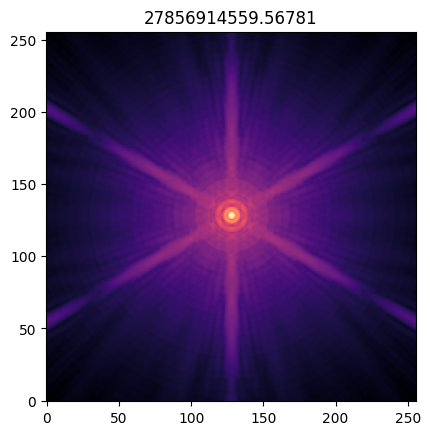

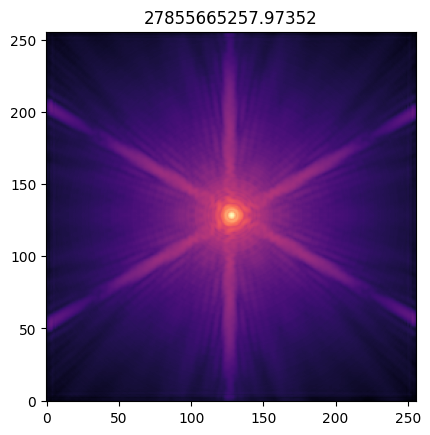

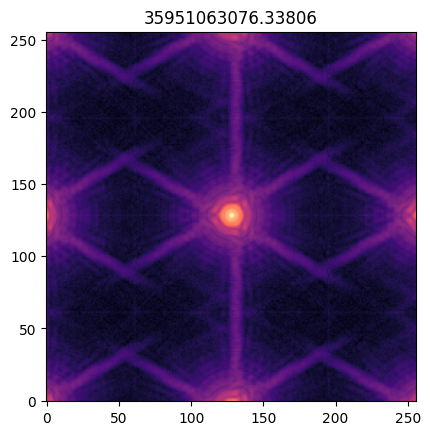

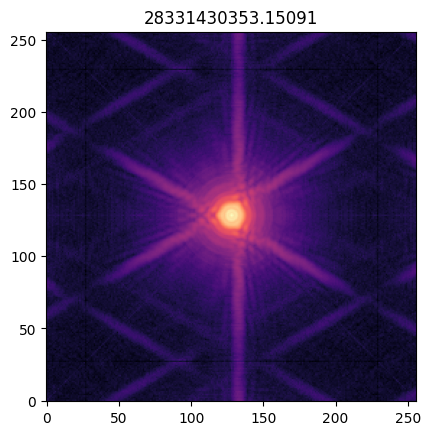

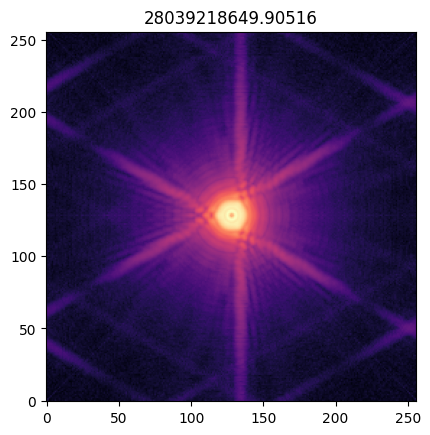

In [ ]:
defocus_values = np.linspace(0, 1, 5)

model = telescope(npix=512,
                  roi=128,
                  wvls=list(np.linspace(0.575, 0.725, 25).get()),
                  wvl_weights=np.ones((25,)),
                  src_magnitudes=[0, 0, 0, 0, 0],
                  src_positions=[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)],
                  defocus_values=defocus_values)

images = model.snap()

for image in images:
    plt.figure()
    plt.imshow(image.get(), cmap='magma', norm='log')
    plt.title(np.sum(image))

In [148]:
# zernike basis
r_norm = model.r_m1 / (6420 / 2)
nms = [noll_to_nm(i) for i in range(2, 37)]
zernikes = list(zernike_nm_seq(nms, model.r_m1, model.t_m1, norm=True))
zernikes = [z / np.max(np.abs(z)) for z in zernikes]

In [149]:
error_fx = 'GIE'
adpr_list = []

for defocus_value, psf in zip(defocus_values, images):
    adpr_list.append(ADPhaseRetireval(amp=model.aperture,
                                          amp_dx=model.dx_m1,
                                          efl=model.efl,
                                          wvls=model.wvls,
                                          basis=np.asarray(zernikes),
                                          target=psf,
                                          img_dx=3.76,
                                          defocus_waves=defocus_value,
                                          initial_phase=None,
                                          error_function=error_fx))




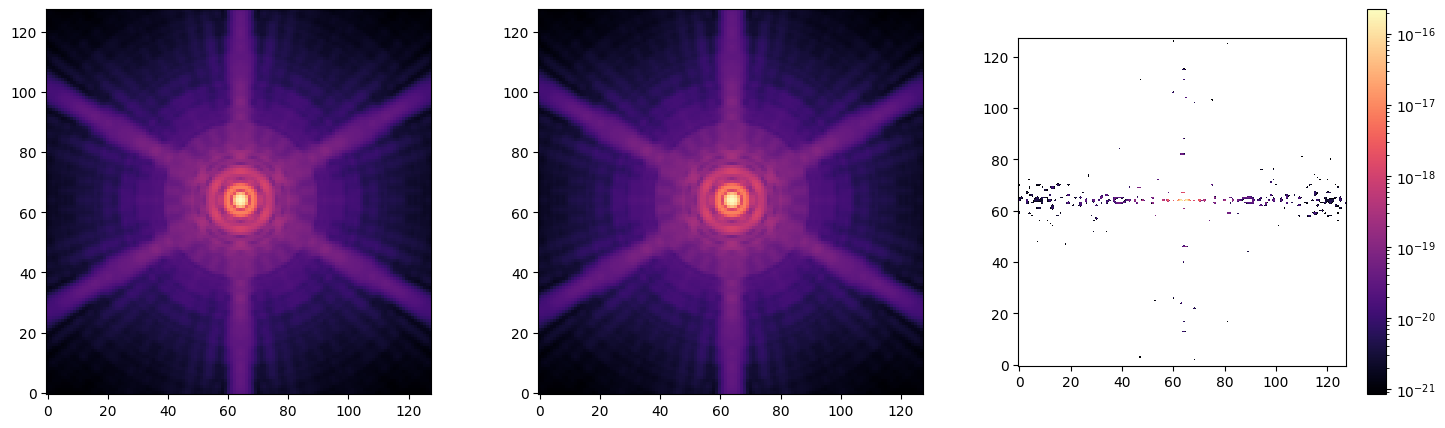

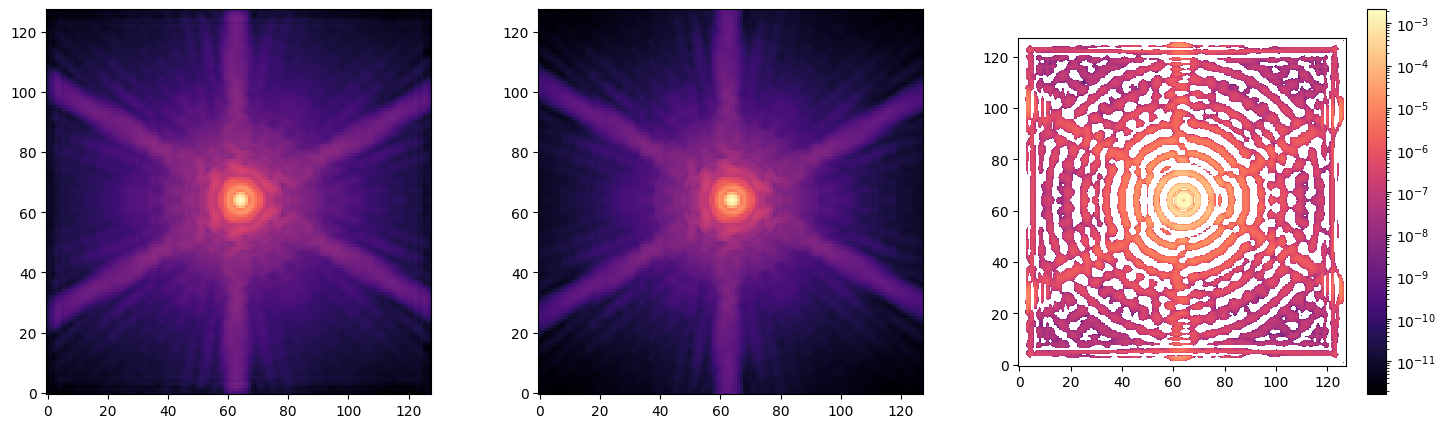

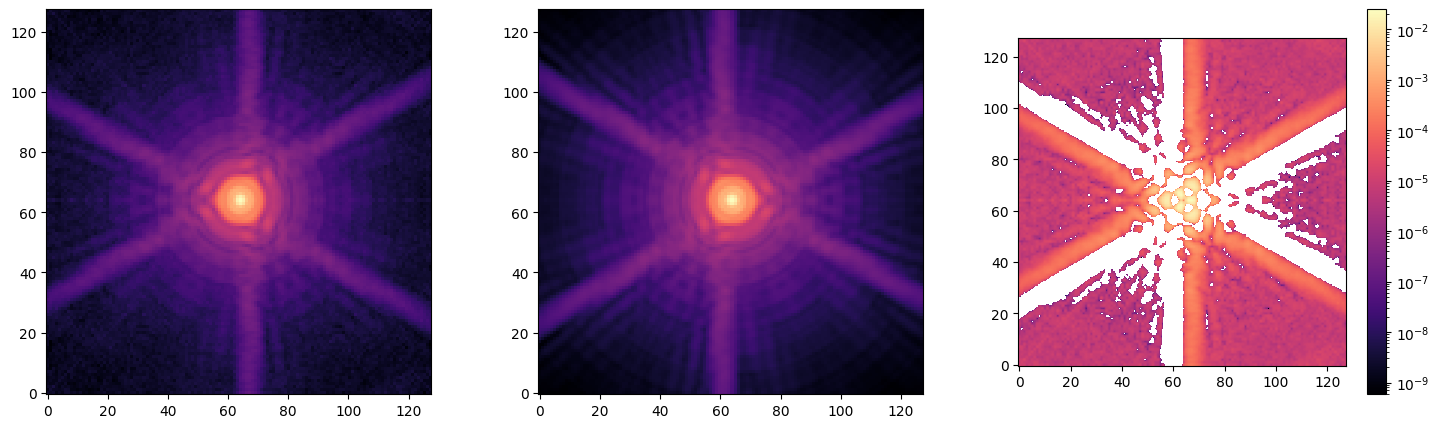

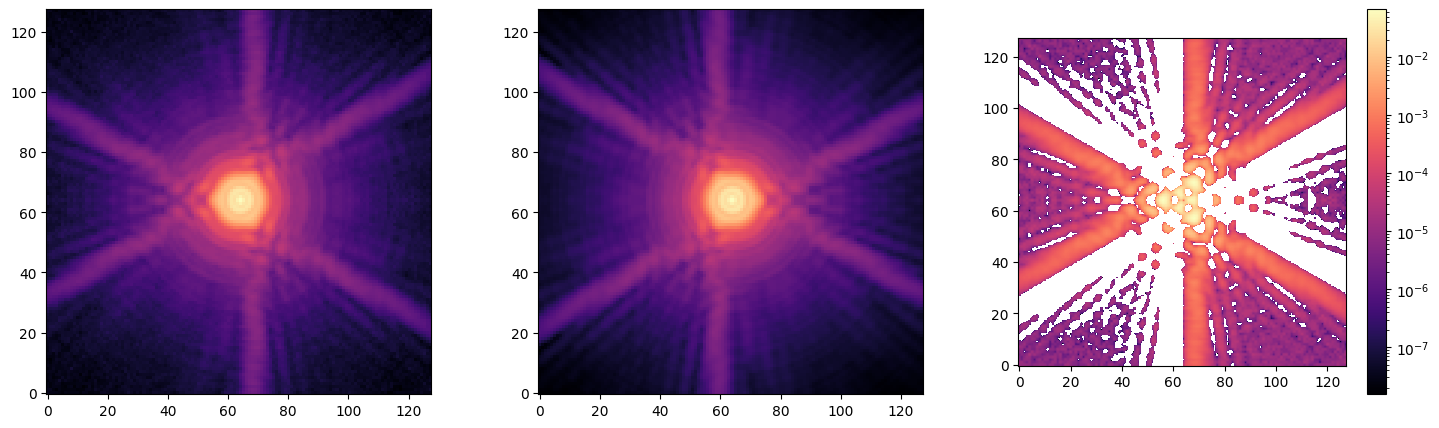

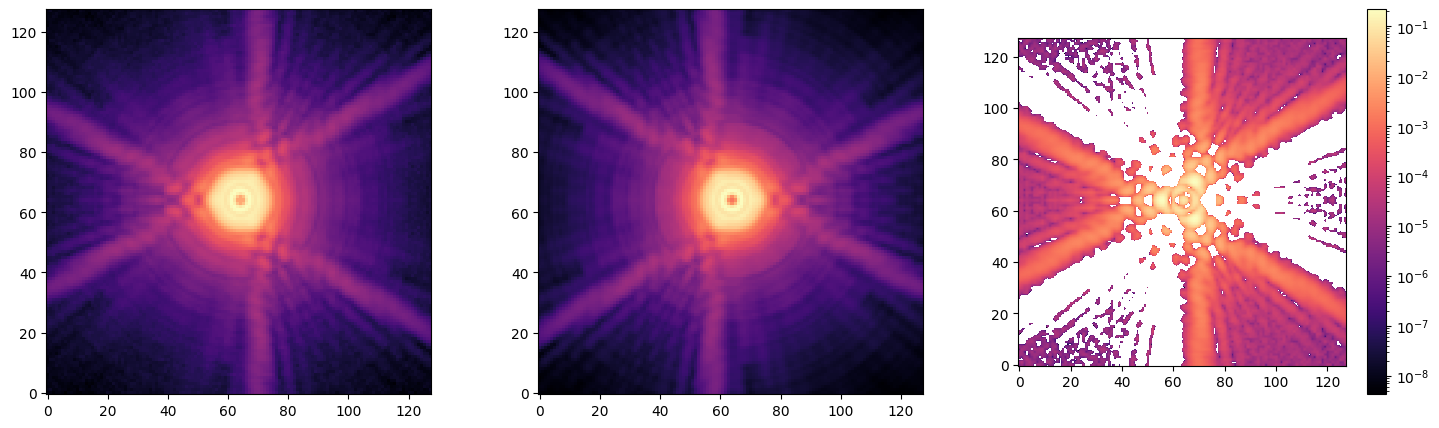

In [150]:
for i, adpr in enumerate(adpr_list):
    adpr.fwd(x=np.zeros((len(zernikes),)))

    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.imshow(images[i].get() / images[i].get().max(), norm='log', cmap='magma')
    plt.subplot(132)
    plt.imshow(adpr.I.get() / adpr.I.get().max(), norm='log', cmap='magma')
    plt.subplot(133)
    plt.imshow(images[i].get() / images[i].get().max() - adpr.I.get() / adpr.I.get().max(), norm='log', cmap='magma')
    plt.colorbar()